### BASIC EDA ON DATASET OF IMAGES

Data overview

In [2]:
import os
from collections import Counter

dir = 'dataset'
dataset = os.listdir(dir)
len(dataset)

10137

In [3]:
counts = {cls: len(os.path.join(dir, cls)) for cls in dataset}
print(len(counts))

10137


Check shape and size of images

In [4]:
from PIL import Image
import numpy as np

In [5]:
sizes = []
for img_name in dataset:
    img = Image.open(os.path.join(dir, img_name))
    sizes.append(img.size)

unique_sizes = Counter(sizes)
print(len(unique_sizes))
print(len(sizes))

4284
10137


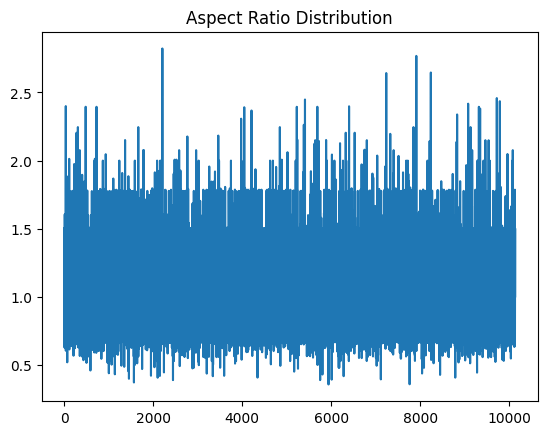

In [6]:
import matplotlib.pyplot as plt

ratios = [w/h for (w,h) in sizes]
plt.plot(ratios)
plt.title("Aspect Ratio Distribution")
plt.show()


In [7]:
set_ratios = set(ratios)
count_dict = {}
for ratio in set_ratios:
    count = ratios.count(ratio)
    count_dict[ratio] = count


In [8]:
max(count_dict.values())

358

### Checking Duplicacy 

In [9]:
import os 
from PIL import Image
import pandas as pd
from tqdm import tqdm
import imagehash

In [10]:
def compute_hash(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        ahash = imagehash.average_hash(img) # capture the overall brightness pattern
        phash = imagehash.phash(img) # capture the perceptual features
        dhash = imagehash.dhash(img) # capture changes between adjacent pixels
        return str(ahash), str(phash), str(dhash) # binary to hex converted
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None, None

In [11]:
hash_data = []
for image in dataset:
    image_path = os.path.join(dir, image)
    ahash, phash, dhash = compute_hash(image_path)
    hash_data.append({
        'image_path' : image,
        'ahash' : ahash,
        'phash' : phash,
        'dhash' : dhash
    })

hash_df = pd.DataFrame(hash_data)
hash_df.head()

,image_path,ahash,phash,dhash
0,16_1_3_20170104222158160.jpg,00d99f9d8186fe3e,9c69c5760297366b,d5333b293b2c3cf4
1,40_1_0_20170105172927477.jpg,1f1f191d1c0e0e06,9988b5964e5b546d,b4bbf35171b8183c
2,71_1_0_20170110181315747.jpg,bfffff7f3f3c0000,8fb15e9f2d01d035,79699ed75f696125
3,80_1_0_20170110141417728.jpg,003c3c3c1c3e7e7c,926f613d6ab43178,71f1f1e97970f4d8
4,21_0_4_20161223214759249.jpg,081c1c3e3e3c3811,9e30694bb1e7706c,b130b4f4e0e86123


In [12]:
def find_duplicated(hash_df, hash_type):
    duplicates = hash_df[hash_df.duplicated(subset=[hash_type], keep=False)]
    groups = duplicates.groupby(hash_type)['image_path'].apply(list).reset_index()
    groups = groups[groups['image_path'].apply(lambda x: len(x) > 1)]
    return groups

In [13]:
duplicated_ahash = find_duplicated(hash_df, 'ahash')
duplicated_ahash.shape


(181, 2)

In [14]:
duplicated_ahash['image_path'].tolist()

[['11_1_4_20161223225953124.jpg', '8_1_4_20170103233220163.jpg'],
 ['30_0_0_20170104201611041.jpg', '27_0_0_20170105164657988.jpg'],
 ['8_1_0_20170109202316791.jpg', '12_1_0_20170109205056743.jpg'],
 ['33_0_0_20170105165028532.jpg', '31_0_0_20170104201726242.jpg'],
 ['1_1_3_20161220221800802.jpg', '1_0_3_20161219230224536.jpg'],
 ['17_1_0_20170109201558943.jpg', '15_1_0_20170109213427133.jpg'],
 ['1_0_4_20170103205312818.jpg', '1_0_4_20161221202127697.jpg'],
 ['2_1_4_20161221202842353.jpg', '3_1_0_20170103213301485.jpg'],
 ['37_0_0_20170104210303340.jpg', '40_0_0_20170105172925445.jpg'],
 ['53_1_0_20170110141616567.jpg', '51_1_0_20170110160643172.jpg'],
 ['60_1_0_20170110151441645.jpg', '60_1_0_20170110154145935.jpg'],
 ['55_0_0_20170111202253255.jpg',
  '53_0_0_20170111200627419.jpg',
  '56_0_0_20170111222411632.jpg'],
 ['8_1_4_20161223230041764.jpg', '8_1_0_20170109204251231.jpg'],
 ['46_1_0_20170110160643141.jpg', '56_1_0_20170110153255801.jpg'],
 ['67_1_0_20170110140452381.jpg', '6

In [18]:
duplicated_phash = find_duplicated(hash_df, 'phash')
duplicated_phash.shape


(169, 2)

In [19]:
duplicated_dhash = find_duplicated(hash_df, 'dhash')
duplicated_dhash.shape


(155, 2)

In [20]:
dup_a = sum(duplicated_ahash['image_path'].tolist(),[])
dup_p = sum(duplicated_phash['image_path'].tolist(),[])
dup_d = sum(duplicated_dhash['image_path'].tolist(),[])
print(f"Length of duplicated ahash {len(dup_a)} phash {len(dup_p)} dhash {len(dup_d)}")

Length of duplicated ahash 376 phash 351 dhash 319


In [29]:
# merging all three hash lists
all_duplicates = []
all_duplicates.extend(dup_a)
all_duplicates.extend(dup_p)
all_duplicates.extend(dup_d)
print(f"Total duplicated images: {len(all_duplicates)}")

Total duplicated images: 1046


In [28]:
# unique duplicated images
unique_duplicates = set(all_duplicates)
print(f"Unique duplicated images: {len(unique_duplicates)}")

Unique duplicated images: 397


In [30]:
# deleting unique duplicated images from total duplicated images
for img_name in unique_duplicates:
    if img_name in all_duplicates:
        all_duplicates.remove(img_name)
print(f"Final duplicated images after removing uniques: {len(all_duplicates)}")

Final duplicated images after removing uniques: 649


In [35]:
# removing this final duplicated images from dataset
for img_name in all_duplicates:
    if img_name in dataset:
        dataset.remove(img_name)
print("Removed duplicated images from dataset.")

Removed duplicated images from dataset.


In [36]:
len(dataset)

9784